In [7]:
import os
import torch
import torch.nn.functional as F
import argparse

from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

import scipy.sparse as sp
import numpy as np

from sklearn.metrics import mean_squared_error
from utils.utils import scipy_to_torch_sparse, genMatrixes, genMatrixesLH
from utils.dataLoader import LandmarksDataset, ToTensor, ToTensorLH, Rescale, RandomScale, AugColor, Rotate

from models.hybridDoubleSkip import Hybrid as DoubleSkip
from models.hybridSkip import Hybrid as Skip
from models.hybrid import Hybrid
from models.hybridNoPool import Hybrid as HybridNoPool

from models.chebConv import Pool
from skimage.metrics import hausdorff_distance as hd

In [11]:
import matplotlib.pyplot as plt

In [8]:
train_path = "Datasets/JSRT/Train"
val_path = "Datasets/JSRT/Val" 

img_path = os.path.join(train_path, 'Images')
label_path = os.path.join(train_path, 'landmarks')

train_dataset = LandmarksDataset(img_path=img_path,
                                     label_path=label_path,
                                     transform = transforms.Compose([
                                                 RandomScale(),
                                                 Rotate(3),
                                                 AugColor(0.40),
                                                 ToTensor()])
                                     )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 0)

0
tensor([[[ 2.7129e-03,  2.6283e-03, -4.2542e-04,  ..., -1.3960e-03,
          -2.2578e-04, -7.0573e-03],
         [-4.0469e-03, -1.3296e-02, -2.6076e-03,  ..., -6.7828e-04,
           4.4315e-03,  2.2747e-03],
         [-2.2478e-03, -1.0020e-02,  9.0418e-03,  ..., -7.1059e-03,
           4.6764e-03, -9.6313e-04],
         ...,
         [ 4.6610e-03,  7.7073e-03, -7.1338e-03,  ...,  1.9858e-03,
          -1.1389e-03,  9.4534e-05],
         [ 1.5759e-03, -1.4493e-02, -5.7484e-03,  ..., -4.2924e-03,
           2.4963e-03,  4.5373e-03],
         [ 2.3090e-03, -1.0718e-02, -1.1535e-02,  ...,  9.7611e-03,
          -1.4320e-02,  8.6863e-03]]])
torch.Size([1, 1024, 1024])


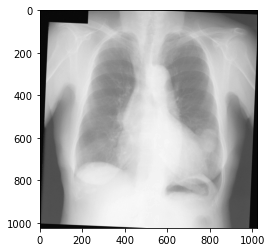

In [14]:
sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
sample_idx=0
print(sample_idx)
img=train_dataset[sample_idx]['image']
print(img)
print(img.size())
plt.imshow(img.squeeze(), cmap="gray")


In [13]:
landmarks=train_dataset[sample_idx]['landmarks']
landmarks


tensor([[0.3440, 0.0386],
        [0.3052, 0.0469],
        [0.2659, 0.0656],
        [0.2263, 0.0899],
        [0.1885, 0.1259],
        [0.1588, 0.1623],
        [0.1337, 0.1989],
        [0.1195, 0.2361],
        [0.1095, 0.2735],
        [0.1006, 0.3109],
        [0.0916, 0.3483],
        [0.0840, 0.3858],
        [0.0786, 0.4234],
        [0.0743, 0.4611],
        [0.0713, 0.4988],
        [0.0705, 0.5367],
        [0.0646, 0.5743],
        [0.0570, 0.6118],
        [0.0439, 0.6490],
        [0.0327, 0.6863],
        [0.0248, 0.7238],
        [0.0184, 0.7614],
        [0.0496, 0.7291],
        [0.0828, 0.7027],
        [0.1180, 0.6833],
        [0.1529, 0.6714],
        [0.1874, 0.6663],
        [0.2215, 0.6680],
        [0.2556, 0.6720],
        [0.2896, 0.6772],
        [0.2918, 0.6330],
        [0.2928, 0.5888],
        [0.2986, 0.5448],
        [0.3065, 0.5009],
        [0.3290, 0.4577],
        [0.3564, 0.4148],
        [0.3738, 0.3714],
        [0.3862, 0.3278],
        [0.4

In [1]:
import numpy as np
landmarks_002=np.load('Datasets/JSRT/Train/landmarks/JPCLN002.npy')
print(landmarks_002)


[364.      97.     331.952  108.     299.905  133.095  267.857  153.143
 249.     185.19   233.762  217.238  226.     249.286  222.     281.333
 215.619  313.381  206.571  345.429  197.     377.476  193.     409.524
 184.429  441.571  179.     473.619  175.     505.667  173.     537.714
 167.238  569.762  160.     601.81   156.     633.857  158.     665.905
 158.     697.952  157.     730.     175.5    698.5    199.     671.
 230.5    660.     262.     657.     293.5    654.     325.     659.
 356.5    670.5    388.     685.     365.     642.333  362.     599.667
 367.     557.     382.667  514.333  385.     471.667  395.     429.
 412.667  386.333  435.     343.667  449.     301.     454.     258.333
 459.     215.667  454.     173.     440.     130.333  406.667   97.
 665.      86.     698.429  103.429  731.857  127.857  761.     161.286
 781.     194.714  790.     228.143  801.571  261.571  811.     295.
 822.429  328.429  829.     361.857  836.286  395.286  842.     428.714
 849.  

In [4]:
import numpy as np
landmarks_002=np.load('/rds/user/hpcpin1/hpc-work/SegProject/Datasets/Cephalometric/Test/landmarks/301.npy')
print(landmarks_002)


[388.43204134 403.2        690.60465116 389.54666667 649.85633075
 476.16       287.35503876 487.25333333 712.30180879 600.32
 693.25064599 769.28       694.30904393 808.53333333 667.84909561
 836.26666667 685.3126615  826.45333333 347.15452196 721.92
 742.46614987 685.65333333 749.8749354  686.50666667 805.44082687
 634.02666667 791.68165375 747.09333333 776.86408269 595.62666667
 762.04651163 794.88       481.57105943 574.29333333 717.06459948
 579.41333333 320.16537468 520.53333333]


In [6]:
from utils.fun import drawOrgans



fig = plt.figure(figsize=(24, 8), dpi= 200)

ax = plt.subplot()

sample = train_dataset[sample_idx]

data, target = sample['image'], sample['landmarks']
data = torch.unsqueeze(data, 0).to('cpu')
target = target.reshape(-1).numpy()

draw = data.cpu().numpy()[0,0,:,:]

plt.xlim(1, 1024)
plt.ylim(1024, 1)

drawOrgans(ax, target[:240] * 1024, None, draw.copy())
plt.title("Ground Truth", fontsize = 20)



NameError: name 'plt' is not defined

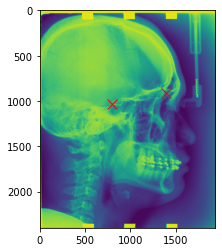

In [5]:
import cv2
import matplotlib.pyplot as plt
cephalo = cv2.imread('/home/hpcpin1/Seg_Project/Datasets/Cephalometric/cepha400/cepha400/395.jpg', 0)
plt.imshow(cephalo)
plt.plot(797, 1034, marker="x", markersize=10, color="red")
plt.plot(1399,908, marker="x", markersize=10, color="red")



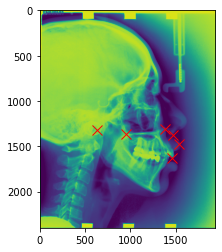

In [12]:
import cv2
import matplotlib.pyplot as plt
cephalo = cv2.imread('/home/hpcpin1/Seg_Project/Datasets/Cytomine/Cephalo/6641948.', 0)
plt.imshow(cephalo)
plt.plot(629, 1323, marker="x", markersize=10, color="red")
plt.plot(1380,1311, marker="x", markersize=10, color="red")
plt.plot(949,1365, marker="x", markersize=10, color="red")
plt.plot(1470,1376, marker="x", markersize=10, color="red")
plt.plot(1542,1471, marker="x", markersize=10, color="red")
plt.plot(1459,1633, marker="x", markersize=10, color="red")

In [13]:
print(cephalo.shape)

(2400, 1935)


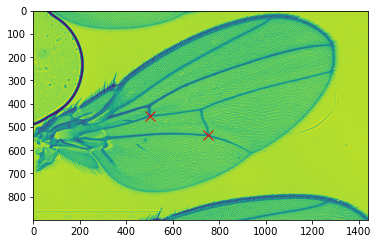

In [10]:
import cv2
import matplotlib.pyplot as plt
cephalo = cv2.imread('/home/hpcpin1/Seg_Project/Datasets/Cytomine/Droso/6603457.', 0)
plt.imshow(cephalo)
plt.plot(751, 535, marker="x", markersize=10, color="red")
plt.plot(501,451, marker="x", markersize=10, color="red")